# Buckley-Leverett two-phase problem
The Buckley-Leverett test problem is a classical reservoir simulation
benchmark that demonstrates the nonlinear displacement process of a viscous
fluid being displaced by a less viscous fluid, typically taken to be water
displacing oil.

## Problem definition

This is a simple model without wells, where the flow is driven by a simple
source term and a simple constant pressure boundary condition at the outlet.
We define a function that sets up a two-phase system, a simple 1D domain and
replaces the default relative permeability functions with quadratic functions:

$k_{r\alpha}(S) = \min \left(\frac{S - S_r}{1 - S_r}, 1\right)^n, S_r = 0.2,
n = 2$

In addition, the phase viscosities are treated as constant parameters of 1 and
5 centipoise for the displacing and resident fluids, respectively.

The function is parametrized on the number of cells and the number of
time-steps used to solve the model. This function, since it uses a relatively
simple setup without wells, uses the `Jutul` functions directly.

In [1]:
using JutulDarcy, Jutul
function solve_bl(;nc = 100, time = 1.0, nstep = nc)
    T = time
    tstep = repeat([T/nstep], nstep)
    domain = get_1d_reservoir(nc)
    nc = number_of_cells(domain)
    timesteps = tstep*3600*24
    bar = 1e5
    p0 = 100*bar
    sys = ImmiscibleSystem((LiquidPhase(), VaporPhase()))
    model = SimulationModel(domain, sys)
    kr = BrooksCoreyRelativePermeabilities(sys, [2.0, 2.0], [0.2, 0.2])
    replace_variables!(model, RelativePermeabilities = kr)
    tot_time = sum(timesteps)
    pv = pore_volume(domain)
    irate = 500*sum(pv)/tot_time
    src  = SourceTerm(1, irate, fractional_flow = [1.0, 0.0])
    bc = FlowBoundaryCondition(nc, p0/2)
    forces = setup_forces(model, sources = src, bc = bc)
    parameters = setup_parameters(model, PhaseViscosities = [1e-3, 5e-3]) # 1 and 5 cP
    state0 = setup_state(model, Pressure = p0, Saturations = [0.0, 1.0])
    states, report = simulate(state0, model, timesteps,
        forces = forces, parameters = parameters, info_level = -1)
    return states, model, report
end

solve_bl (generic function with 1 method)

## Run the base case
We solve a small model with 100 cells and 100 steps to serve as the baseline.

In [2]:
n, n_f = 100, 1000
states, model, report = solve_bl(nc = n)
print_stats(report)

╭────────────────┬───────────┬───────────────┬──────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │ Time per │    Total │
│                │ 100 steps │ 100 ministeps │       ms │ (wasted) │
├────────────────┼───────────┼───────────────┼──────────┼──────────┤
│ Newton         │      3.31 │          3.31 │   2.5188 │  331 (0) │
│ Linearization  │      4.31 │          4.31 │   1.9344 │  431 (0) │
│ Linear solver  │      3.31 │          3.31 │   2.5188 │  331 (0) │
╰────────────────┴───────────┴───────────────┴──────────┴──────────╯
╭────────────────┬────────┬────────────┬──────────╮
│ Timing type    │   Each │   Relative │    Total │
│                │     ms │ Percentage │       ms │
├────────────────┼────────┼────────────┼──────────┤
│ Properties     │ 0.0123 │     0.49 % │   4.0852 │
│ Equations      │ 0.5601 │    28.96 % │ 241.4026 │
│ Assembly       │ 0.0063 │     0.32 % │   2.7042 │
│ Linear solve   │ 0.2181 │     8.66 % │  72.1911 │
│ Preconditioner │ 0.0000 │     

## Run refined version (1000 cells, 1000 steps)
Using a grid with 100 cells will not yield a fully converged solution. We can
increase the number of cells at the cost of increasing the runtime a bit. Note
that most of the time is spent in the linear solver, which uses a direct
sparse LU factorization by default. For larger problems it is recommended to
use an iterative solver.

In [3]:
states_refined, _, report_refined = solve_bl(nc = n_f);
print_stats(report_refined)

╭────────────────┬────────────┬────────────────┬──────────┬──────────╮
│ Iteration type │   Avg/step │   Avg/ministep │ Time per │    Total │
│                │ 1000 steps │ 1000 ministeps │       ms │ (wasted) │
├────────────────┼────────────┼────────────────┼──────────┼──────────┤
│ Newton         │      3.265 │          3.265 │   1.9758 │ 3265 (0) │
│ Linearization  │      4.265 │          4.265 │   1.5126 │ 4265 (0) │
│ Linear solver  │      3.265 │          3.265 │   1.9758 │ 3265 (0) │
╰────────────────┴────────────┴────────────────┴──────────┴──────────╯
╭────────────────┬────────┬────────────┬────────╮
│ Timing type    │   Each │   Relative │  Total │
│                │     ms │ Percentage │      s │
├────────────────┼────────┼────────────┼────────┤
│ Properties     │ 0.0677 │     3.42 % │ 0.2209 │
│ Equations      │ 0.0499 │     3.30 % │ 0.2128 │
│ Assembly       │ 0.0479 │     3.17 % │ 0.2044 │
│ Linear solve   │ 1.7117 │    86.63 % │ 5.5889 │
│ Preconditioner │ 0.0000 │     

## Plot results
We plot the saturation front for the base case at different times together
with the final solution for the refined model. In this case, refining the grid
by a factor 10 gave us significantly less smearing of the trailing front.

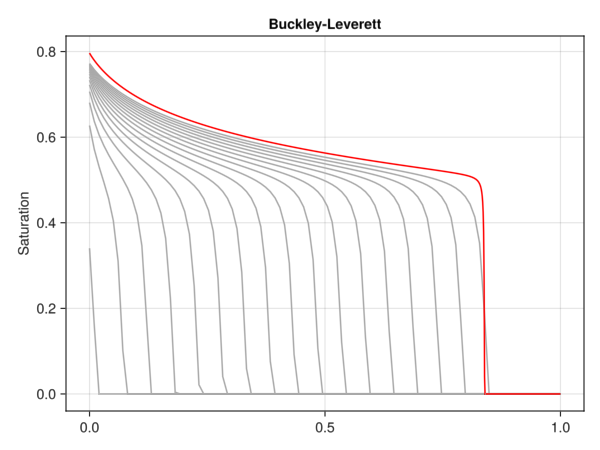

In [4]:
using GLMakie
x = range(0, stop = 1, length = n)
x_f = range(0, stop = 1, length = n_f)
f = Figure()
ax = Axis(f[1, 1], ylabel = "Saturation", title = "Buckley-Leverett")
for i in 1:6:length(states)
    lines!(ax, x, states[i][:Saturations][1, :], color = :darkgray)
end
lines!(ax, x_f, states_refined[end][:Saturations][1, :], color = :red)
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*